# Telco Customer Churn — Project Overview

Elevator pitch: Predict which telecom customers are most likely to churn and surface the business drivers so the company can target retention efforts effectively.

Dataset: 5,986 customers (Telco Customer Churn). Source: Kaggle data file.

Primary objective:
- Build understandable, reproducible models to predict customer churn (binary target `Churn`).
- Explain why a customer is at risk (actionable drivers) using feature importance and SHAP.

What this notebook contains:
- EDA and data-cleaning assumptions (e.g., handling `TotalCharges` and new customers).
- Feature engineering that encodes product engagement and billing patterns.
- Baseline and stronger models (Logistic Regression, Random Forest, CatBoost) with hyperparameter tuning.
- Explainability (coefficients + SHAP) and an ensemble comparison to select a production candidate.

### Data columns

- `customerID` - customer id  
- `gender` - client gender (male / female)  
- `SeniorCitizen` - is the client retired (1, 0)  
- `Partner` - is the client married (Yes, No)  
- `tenure` - how many months a person has been a client of the company  
- `PhoneService` - is the telephone service connected (Yes, No)  
- `MultipleLines` - are multiple phone lines connected (Yes, No, No phone service)  
- `InternetService` - client’s Internet service provider (DSL, Fiber optic, No)  
- `OnlineSecurity` - is the online security service connected (Yes, No, No internet service)  
- `OnlineBackup` - is the online backup service activated (Yes, No, No internet service)  
- `DeviceProtection` - does the client have equipment insurance (Yes, No, No internet service)  
- `TechSupport` - is the technical support service connected (Yes, No, No internet service)  
- `StreamingTV` - is the streaming TV service connected (Yes, No, No internet service)  
- `StreamingMovies` - is the streaming cinema service activated (Yes, No, No internet service)  
- `Contract` - type of customer contract (Month-to-month, One year, Two year)  
- `PaperlessBilling` - whether the client uses paperless billing (Yes, No)  
- `PaymentMethod` - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))  
- `MonthlyCharges` - current monthly payment  
- `TotalCharges` - the total amount that the client paid for the services for the entire time  
- `Churn` - whether there was a churn (Yes or No)  


## Guided explanation of the notebook sections

### 1) EDA & Cleaning
- Inspect basic types and distributions (`df.info()`, `df.nunique()`, histograms).
- Key assumption: `TotalCharges` may be blank for very new customers; we coerce to numeric and fill missing with 0 (documented).
- Remove duplicates and drop `customerID` as an identifier not used for modeling.

### 2) Feature engineering
- `Services_Count`: counts active add-on services (proxy for engagement / product penetration).
- `AvgCharge` = TotalCharges / (tenure + 1): simple lifetime-average monthly charge (+1 avoids div-by-zero).
- `CurrentChargeOverHistorical` = MonthlyCharges - AvgCharge: flags customers whose current bill is unusually high vs historical average.
- `Tariff_VeryLow`: bucket for low monthly-payment customers; `HasInternetService` and consistency fixes for dependent columns.

Why these matter: churn often correlates with low tenure, month-to-month contracts, and billing surprises or dissatisfaction reflected by a spike in `CurrentChargeOverHistorical`.

### 3) Preprocessing pipeline
- Numeric features are scaled with `StandardScaler`.
- Categorical features are one-hot encoded (`OneHotEncoder(handle_unknown='ignore')`).
- ColumnTransformer wraps numeric and categorical pipelines for reuse and proper feature name handling.

### 4) Modeling approach
- Baseline: Logistic Regression (interpretable coefficients). Two versions: unweighted and class-weighted to address imbalance.
- Stronger models: Random Forest (tree ensemble) and CatBoost (handles categorical features natively and often gives best baseline performance).
- For each model: train/validation split with stratification, hyperparameter grid search (ROC AUC scoring), and final evaluation on the test set.

### 5) Model comparison & ensemble
- Compare models by ROC AUC and class-specific metrics (precision/recall/F1 for the churn class).
- A soft VotingClassifier combines strengths of multiple models to improve robustness.

### 6) Explainability
- Logistic Regression coefficients give directionality (positive coefficient → higher odds of churn).
- CatBoost feature importances provide global signal; SHAP is used for local and global interpretability to explain individual predictions.

### 7) Key assumptions & edge cases
- Filling `TotalCharges` with 0 assumes new customers; if billing data is missing for other reasons, this can bias features.
- Adding `+1` to `tenure` prevents divide-by-zero but slightly biases averages for zero-tenure customers—document this assumption in the notebook.
- Treat `SeniorCitizen` consistently (it appears numeric; consider converting to categorical 'Yes'/'No' for some analyses).

### 8) Evaluation guidance (business-oriented)
- Prioritize recall (catching churners) if retention outreach cost is low and revenue loss from churn is high. If outreach cost is high, trade off for precision.
- Calibrate probabilities before using them to trigger marketing actions (isotonic or Platt scaling).

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
#from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# EDA

## Load and inspect the dataset

In [2]:
# Load data
df = pd.read_csv("./data.csv", index_col=0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


## Drop duplicated

In [3]:
df.map(lambda x: x.strip().lower() if isinstance(x, str) else x, na_action='ignore')
df.drop_duplicates(inplace=True)

## Drop 'customerID'

In [4]:
# Drop unnecessary columns
df.drop('customerID', axis=1, inplace=True)

## Check dtype and unique

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5986 entries, 1869 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 
 17

In [6]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1526
TotalCharges        5611
Churn                  2
dtype: int64

In [7]:
# Show unique values for each column in a readable format
for col in df.columns:
    print(f"{col}:")
    print(df[col].unique())

gender:
['Male' 'Female']
SeniorCitizen:
[0 1]
Partner:
['Yes' 'No']
Dependents:
['Yes' 'No']
tenure:
[72 44 38  4  2 70 33  1 39 55 52 30 60 50 32 51 69 42 14 62  5 63 67 40
 65 16 46 11 49 68 10 53 54 15  3 71  8 64 57 20 26 31  7 35  6 13 23  9
 45 17 34 58 12 25 28 29 43 19 41 37 27 22 24 18 56 66 59 48 47 61 21  0
 36]
PhoneService:
['Yes' 'No']
MultipleLines:
['Yes' 'No' 'No phone service']
InternetService:
['No' 'Fiber optic' 'DSL']
OnlineSecurity:
['No internet service' 'No' 'Yes']
OnlineBackup:
['No internet service' 'Yes' 'No']
DeviceProtection:
['No internet service' 'Yes' 'No']
TechSupport:
['No internet service' 'No' 'Yes']
StreamingTV:
['No internet service' 'Yes' 'No']
StreamingMovies:
['No internet service' 'No' 'Yes']
Contract:
['Two year' 'Month-to-month' 'One year']
PaperlessBilling:
['No' 'Yes']
PaymentMethod:
['Credit card (automatic)' 'Bank transfer (automatic)' 'Electronic check'
 'Mailed check']
MonthlyCharges:
[24.1  88.15 74.95 ... 59.25 35.35 21.15]
TotalChar

## Convert `TotalCharges` to numeric and fill nan with 0

In [8]:
# 'TotalCharges' is object type – convert it to numeric
# Strip whitespaces and convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", pd.NA), errors='coerce')

In [9]:

"""
The 'Tenure' is 0 where 'TotalCharges' is NaN. 
They could be assumed to be new customers who have not yet been charged.
"""

df[df['TotalCharges'].isnull()] # Check for any remaining missing values in TotalCharges


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No


In [10]:
# Fill missing TotalCharges with 0 (assuming new customers)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [11]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Convert target encoding: 1, 0

In [12]:
# Target coding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5986 entries, 1869 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 
 17

## Value counts

In [14]:
# Value counts for categorical columns
pd.DataFrame([(col, df.value_counts(col)) for col in df.columns if df[col].dtype == 'object'])

# Show value counts for each categorical column in a readable format
for col in df.columns:
    if df[col].dtype == 'object':
        print(df[col].value_counts().to_string())

gender
Male      3050
Female    2936
Partner
No     3082
Yes    2904
Dependents
No     4195
Yes    1791
PhoneService
Yes    5396
No      590
MultipleLines
No                  2848
Yes                 2548
No phone service     590
InternetService
Fiber optic    2627
DSL            2068
No             1291
OnlineSecurity
No                     2982
Yes                    1713
No internet service    1291
OnlineBackup
No                     2605
Yes                    2090
No internet service    1291
DeviceProtection
No                     2640
Yes                    2055
No internet service    1291
TechSupport
No                     2960
Yes                    1735
No internet service    1291
StreamingTV
No                     2389
Yes                    2306
No internet service    1291
StreamingMovies
No                     2356
Yes                    2339
No internet service    1291
Contract
Month-to-month    3269
Two year          1441
One year          1276
PaperlessBilling
Yes    352

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>],
       [<Axes: title={'center': 'Churn'}>, <Axes: >]], dtype=object)

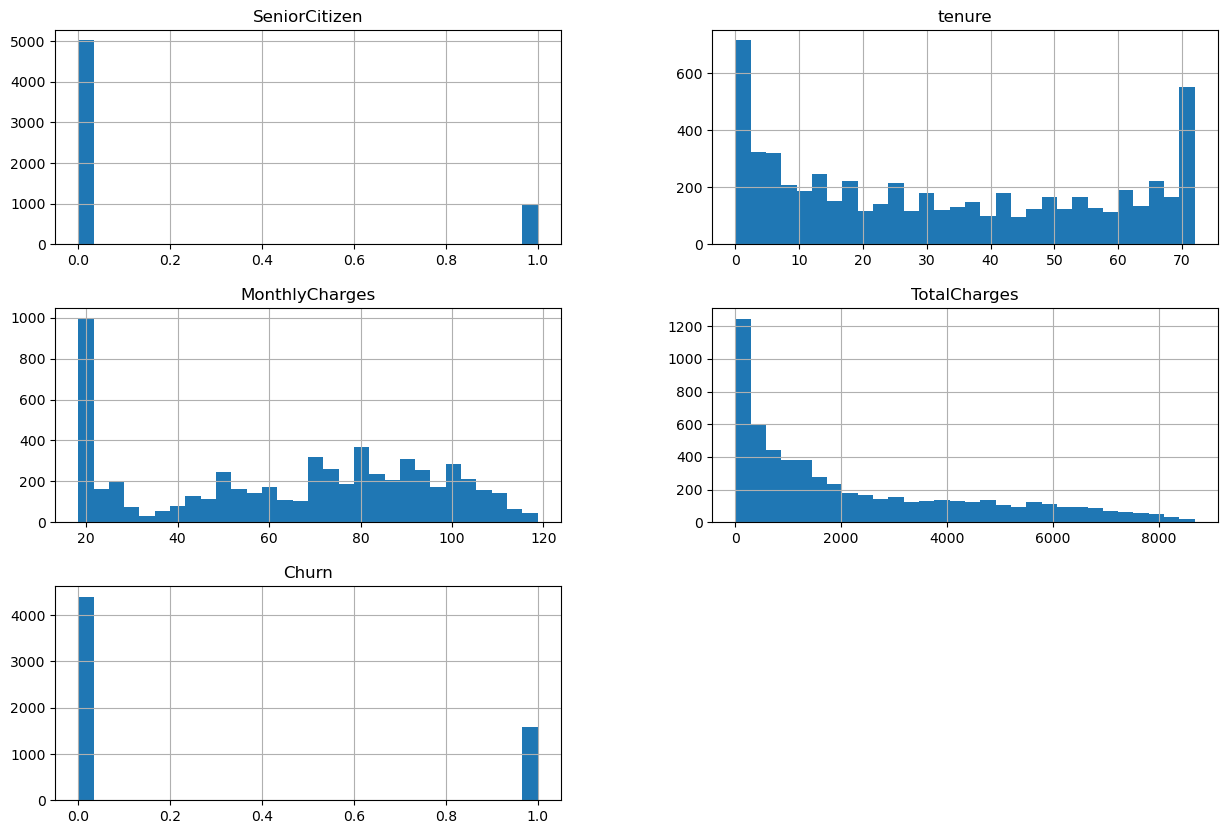

In [15]:
df.hist(figsize=(15, 10), bins=30)

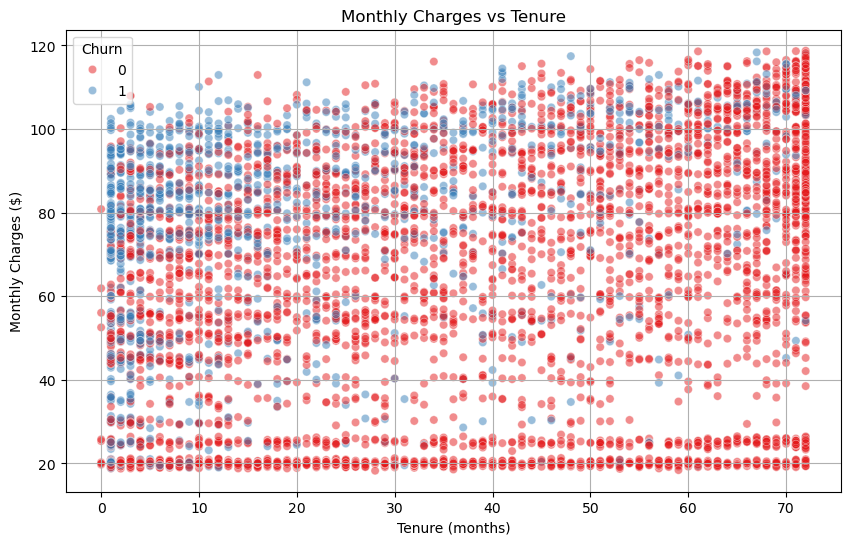

In [16]:
# Plot MonthlyCharges vs Tenure with color by Churn
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.5, palette='Set1')
plt.title('Monthly Charges vs Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.grid()
plt.show()

# Feature engineering

In [17]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

  # Service Engagement
    svc_cols = [
        "PhoneService", "MultipleLines",
        "OnlineSecurity", "OnlineBackup",
        "DeviceProtection", "TechSupport",
        "StreamingTV", "StreamingMovies"
    ]

    # 1. Count how many of those services are explicitly "Yes"
    out["Services_Count"] = out[svc_cols].apply(lambda r: (r == "Yes").sum(), axis=1)

    # 2. Pricing / billing dynamics
    #  (=  MonthlyCharges − TotalCharges / tenure)
    out['AvgCharge'] = out['TotalCharges'] / (out['tenure']+1)  # +1 to avoid div-by-zero

    # Current minus historical average monthly rate
    #   (=  MonthlyCharges − TotalCharges / tenure)
    out["CurrentChargeOverHistorical"] = (
        out["MonthlyCharges"] -
        out["TotalCharges"] / (out["tenure"]+1)  # +1 to avoid div-by-zero
    )

    # 3. Tariff very-low bucket
    out["Tariff_VeryLow"] = out['MonthlyCharges'].apply(lambda x: 'Yes' if x <= 25.5 else 'No')

    # 4. Simplify dependent columns: e.g., set MultipleLines = No if PhoneService = No.
    # Data consistency: Ensures logical relationships between features
    out['MultipleLines'] = out.apply(lambda row: 'No' if row['PhoneService'] == 'No' else row['MultipleLines'], axis=1)

    out['HasInternetService'] = (out['InternetService'] != 'No').astype(int) # either 'fiber optic' or 'DSL'
    for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
        out[col] = out.apply(lambda row: 'No' if row['InternetService'] == 'No' else row[col], axis=1)

    return out

df = add_features(df)

In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Services_Count,AvgCharge,CurrentChargeOverHistorical,Tariff_VeryLow,HasInternetService
1869,Male,0,Yes,Yes,72,Yes,Yes,No,No,No,...,No,Credit card (automatic),24.10,1734.65,0,2,23.762329,0.337671,Yes,0
4528,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,...,Yes,Credit card (automatic),88.15,3973.20,0,4,88.293333,-0.143333,No,1
6344,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,...,Yes,Bank transfer (automatic),74.95,2869.85,1,2,73.585897,1.364103,No,1
6739,Male,0,No,No,4,Yes,No,DSL,No,No,...,Yes,Electronic check,55.90,238.50,0,2,47.700000,8.200000,No,1
432,Male,0,No,No,2,Yes,No,DSL,Yes,No,...,No,Electronic check,53.45,119.50,0,3,39.833333,13.616667,No,1


# Preprocessing

# Train-test split

In [19]:
# Train-test split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [20]:
# Update the num_features and cat_features
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Services_Count', 'AvgCharge', 'CurrentChargeOverHistorical']

cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod','Tariff_VeryLow', 'HasInternetService']

# Logistic regression (baseline model)

## Preprocessing

In [21]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

## No weights

In [22]:
# Logistic regression model
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000, random_state=42))
])

# Fit the model
logistic_pipeline.fit(X_train, y_train)
# Predictions
y_pred_logistic = logistic_pipeline.predict(X_test)
# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))
# ROC AUC Score
roc_auc_logistic = roc_auc_score(y_test, logistic_pipeline.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score (Logistic Regression): {roc_auc_logistic:.4f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       880
           1       0.65      0.50      0.57       318

    accuracy                           0.80      1198
   macro avg       0.74      0.70      0.72      1198
weighted avg       0.79      0.80      0.79      1198

ROC AUC Score (Logistic Regression): 0.8318


## With weights

In [23]:
# Class weights for imbalanced dataset
neg, pos = y.value_counts()
class_weights = {0: 1, 1: neg/pos}  # Adjust weights as needed

# Logistic regression model
logistic_pipeline_w = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000, class_weight=class_weights, random_state=42))
])

# Fit the model
logistic_pipeline_w.fit(X_train, y_train)

# Predictions
y_pred_logistic = logistic_pipeline_w.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# ROC AUC Score
roc_auc_logistic = roc_auc_score(y_test, logistic_pipeline_w.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score (Logistic Regression): {roc_auc_logistic:.4f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       880
           1       0.50      0.76      0.60       318

    accuracy                           0.74      1198
   macro avg       0.70      0.74      0.70      1198
weighted avg       0.79      0.74      0.75      1198

ROC AUC Score (Logistic Regression): 0.8321


## Hyperparameter tuning with weights

In [27]:
# Tuning Logistic Regression with Grid Search
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}
grid_search_logistic = GridSearchCV(logistic_pipeline_w, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_logistic.fit(X_train, y_train)

# Best parameters
print("Best parameters for Logistic Regression:", grid_search_logistic.best_params_)

# Predictions with best model
y_pred_logistic_best = grid_search_logistic.predict(X_test)
# Evaluation with best model
print("Logistic Regression Classification Report (Best Model):")
print(classification_report(y_test, y_pred_logistic_best))

# ROC AUC Score with best model
roc_auc_logistic_best = roc_auc_score(y_test, grid_search_logistic.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score (Logistic Regression Best Model): {roc_auc_logistic_best:.4f}")

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Logistic Regression Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       880
           1       0.50      0.75      0.60       318

    accuracy                           0.74      1198
   macro avg       0.70      0.74      0.70      1198
weighted avg       0.79      0.74      0.75      1198

ROC AUC Score (Logistic Regression Best Model): 0.8312


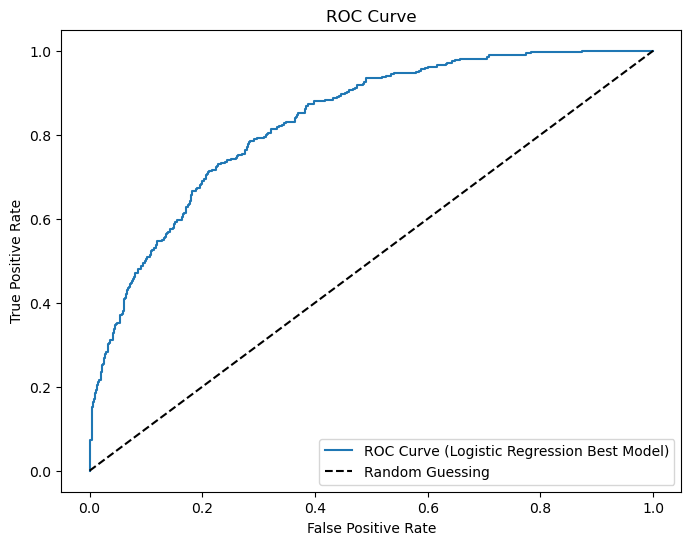

In [28]:
# Plot ROC curve for the best model from Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, grid_search_logistic.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (Logistic Regression Best Model)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

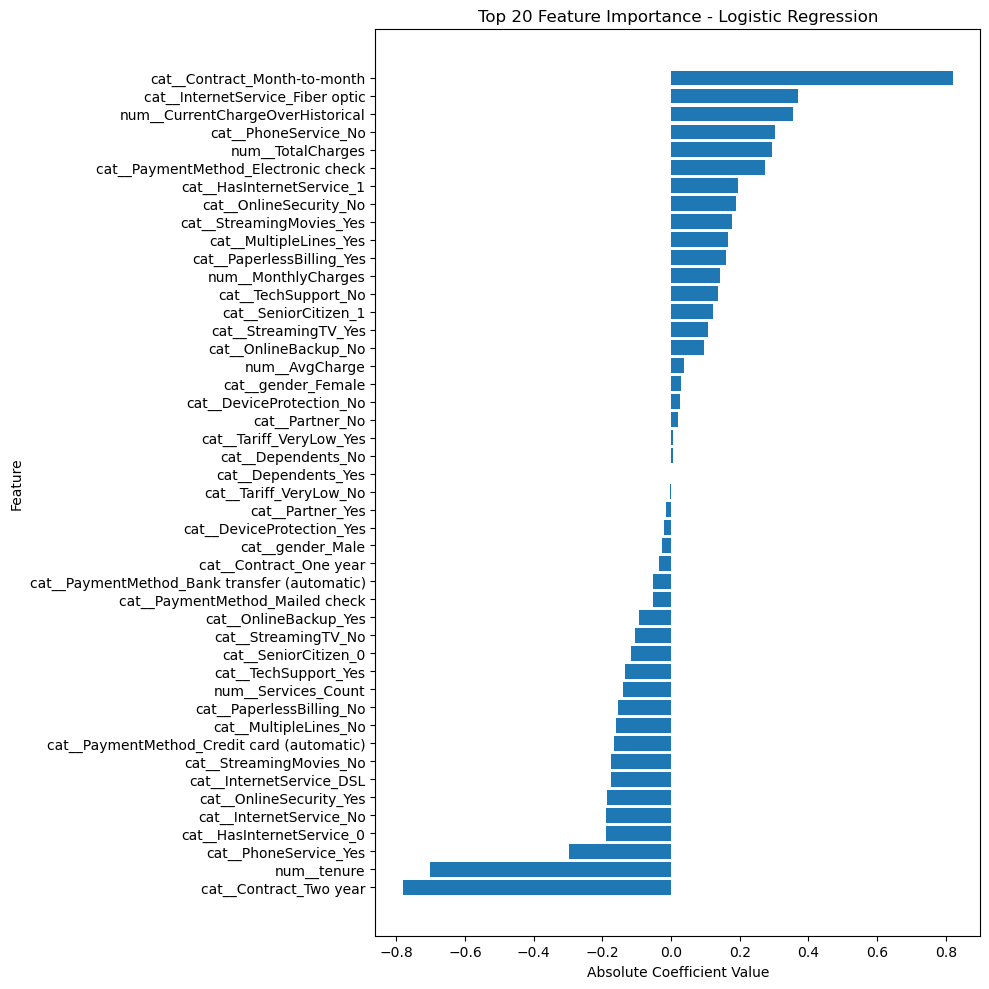

In [ ]:
# Get feature importance from Logistic Regression
def get_feature_importance_lr(pipeline):
    # Get the feature names after preprocessing
    feature_names_after_preprocessing = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Get coefficients from the model
    coefficients = pipeline.named_steps['classifier'].coef_[0]
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'feature': feature_names_after_preprocessing,
        'importance': coefficients #np.abs(coefficients)
    })
    
    # Sort by importance
    return feature_importance.sort_values('importance', ascending=False)

# Get feature importance from the best model
feature_importance_lr = get_feature_importance_lr(grid_search_logistic.best_estimator_)

# Plot feature importance (reverse order for horizontal bar plot)
plt.figure(figsize=(10, 10))
plt.barh(
    feature_importance_lr['feature'][::-1], 
    feature_importance_lr['importance'][::-1]
)
plt.title('Top 20 Feature Importance - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# CatBoost
* Especially good if you have lots of categorical features
* Minimal preprocessing needed

## Weights

### Baseline

In [25]:
import shap
from catboost import CatBoostClassifier, Pool

# Ensure all categorical columns are string type for CatBoost
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# CatBoost Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Assign weights inversely proportional to their frequency
neg, pos = y_train.value_counts()
class_weights = [1, neg / pos]

cbc = CatBoostClassifier(
    cat_features=cat_features,
    class_weights=class_weights,
    random_state=42,
    verbose=0
)
cbc.fit(train_pool)

# Predict and evaluate
y_pred = cbc.predict(test_pool)
y_prob = cbc.predict_proba(test_pool)[:, 1]
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# SHAP Explainability
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.75      0.82       880
           1       0.52      0.75      0.61       318

    accuracy                           0.75      1198
   macro avg       0.71      0.75      0.71      1198
weighted avg       0.79      0.75      0.76      1198


ROC AUC: 0.829191680960549

Confusion Matrix:
 [[661 219]
 [ 80 238]]


### Feature importance

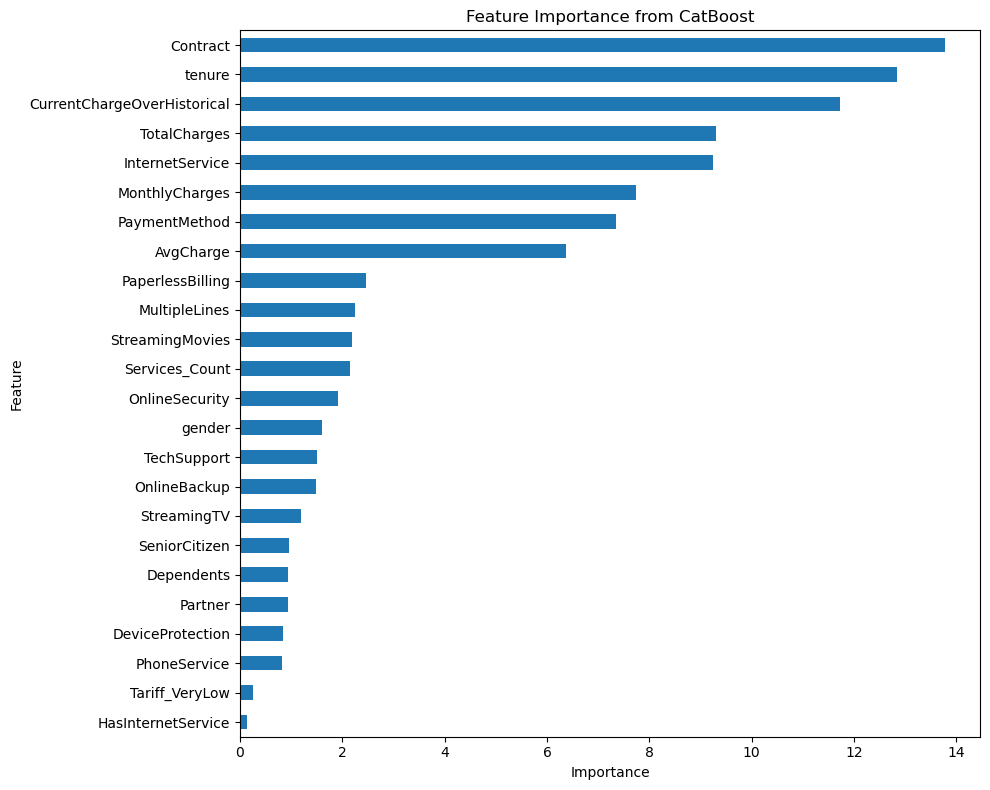

In [33]:
# Feature importance from CatBoost
fi_catboost = pd.Series(cbc.get_feature_importance(), index=X_train.columns).sort_values(ascending=True)

# Visualize feature importance
fi_catboost.plot(kind='barh', figsize=(10, 8), title='Feature Importance from CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Hyperparameter tuning

In [34]:
# Hyperparameter Tuning for CatBoost using Grid Search

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# Define parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500],
    'l2_leaf_reg': [1, 3, 5]
}

# Set up stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use ROC AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, response_method='predict_proba')

# Grid Search
grid_search = GridSearchCV(
    estimator=cbc,
    param_grid=param_grid,
    scoring=scorer,
cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best ROC AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best ROC AUC Score: 0.848095268075052


In [35]:
# Test the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Evaluation of the best model
print("\nBest Model Classification Report:\n", classification_report(y_test, y_pred_best))
print("\nBest Model ROC AUC:", roc_auc_score(y_test, y_prob_best))


Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80       880
           1       0.50      0.78      0.61       318

    accuracy                           0.73      1198
   macro avg       0.70      0.75      0.70      1198
weighted avg       0.79      0.73      0.75      1198


Best Model ROC AUC: 0.83311713836478


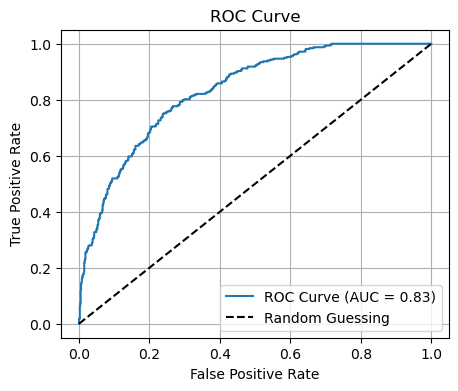

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_best)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Random Forest

In [37]:
# Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
])
# Fit the Random Forest model
rf_pipeline.fit(X_train, y_train)
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
# ROC AUC Score
roc_auc_rf = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score (Random Forest): {roc_auc_rf:.4f}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       880
           1       0.63      0.49      0.55       318

    accuracy                           0.79      1198
   macro avg       0.73      0.69      0.71      1198
weighted avg       0.78      0.79      0.78      1198

ROC AUC Score (Random Forest): 0.8111


In [38]:
# Hyperparameter Tuning for Random Forest using Grid Search
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
# Fit grid search
grid_search_rf.fit(X_train, y_train)
# Best parameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
# Predictions with best model
y_pred_rf_best = grid_search_rf.predict(X_test)

Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}


In [39]:
# Evaluation with best model
print("Random Forest Classification Report (Best Model):")
print(classification_report(y_test, y_pred_rf_best))
# ROC AUC Score with best model
roc_auc_rf_best = roc_auc_score(y_test, grid_search_rf.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score (Random Forest Best Model): {roc_auc_rf_best:.4f}")

Random Forest Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       880
           1       0.53      0.71      0.61       318

    accuracy                           0.76      1198
   macro avg       0.71      0.74      0.72      1198
weighted avg       0.79      0.76      0.77      1198

ROC AUC Score (Random Forest Best Model): 0.8275


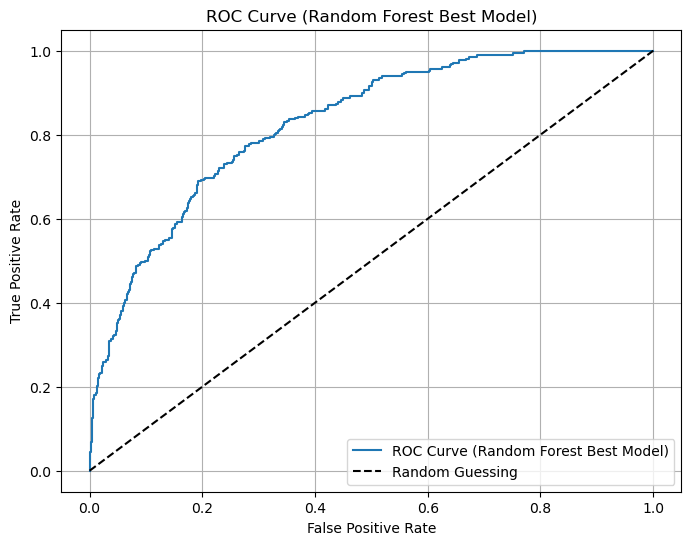

In [40]:
# Plot ROC curve for the best model from Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, grid_search_rf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='ROC Curve (Random Forest Best Model)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest Best Model)')
plt.legend()
plt.grid()
plt.show()

# Compare LogisticRegression, RandomForest, CatBoost best models

In [ ]:
# Compare LogisticRegression, RandomForest, CatBoost best models
def compare_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        results[name] = {
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
    return results
# Define models to compare
models_to_compare = {
    'Logistic Regression': grid_search_logistic.best_estimator_,
    'CatBoost': best_model,
    'Random Forest': grid_search_rf.best_estimator_
}

# Compare models
comparison_results = compare_models(models_to_compare, X_test, y_test)

In [ ]:
# Aggregate results into a DataFrame
comparison_df = pd.DataFrame({
    'Model': [],
    'ROC AUC': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
})

for model_name, result in comparison_results.items():
    report = result['classification_report']
    new_row = pd.DataFrame([{
        'Model': model_name,
        'ROC AUC': result['roc_auc'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    }])
    comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

In [92]:
comparison_df.sort_values(by='ROC AUC', ascending=False, inplace=True)
# Display the comparison DataFrame
print("\nModel Comparison Results:")
print(comparison_df)


Model Comparison Results:
                 Model   ROC AUC  Precision    Recall  F1-Score
1             CatBoost  0.839404   0.497065  0.806349  0.615012
2        Random Forest  0.835470   0.532110  0.736508  0.617843
0  Logistic Regression  0.835271   0.492063  0.787302  0.605617


# Voter Ensemble of the Best Models

In [93]:
# Voter Ensemble of the Best Models
from sklearn.ensemble import VotingClassifier
# Create a voting classifier with the best models
voting_clf = VotingClassifier(
    estimators=[
        ('logistic', grid_search_logistic.best_estimator_),
        ('catboost', best_model),
        #('catboost_smote', best_model_smote)
    ],
    voting='soft'
)
# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred_voting = voting_clf.predict(X_test)
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

# Evaluation of the voting classifier
print("\nVoting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))

# ROC AUC Score for the voting classifier
roc_auc_voting = roc_auc_score(y_test, y_prob_voting)
print(f"ROC AUC Score (Voting Classifier): {roc_auc_voting:.4f}")

# Save the voting classifier model
with open('voting_classifier_model.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)


Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       879
           1       0.50      0.78      0.61       315

    accuracy                           0.73      1194
   macro avg       0.70      0.75      0.70      1194
weighted avg       0.80      0.73      0.75      1194

ROC AUC Score (Voting Classifier): 0.8384


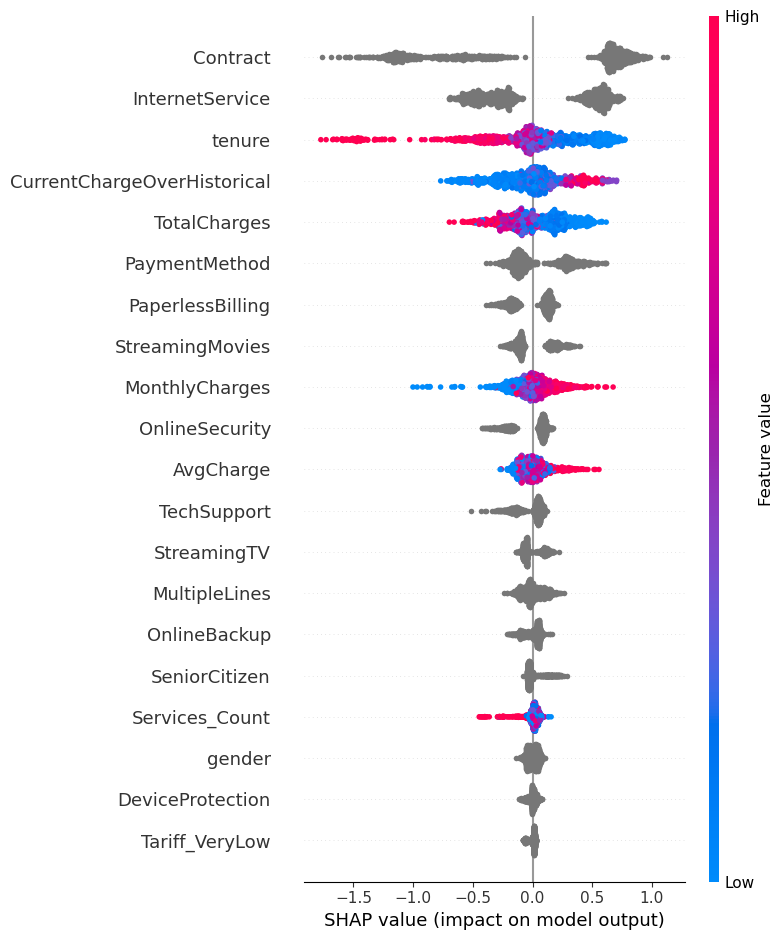

In [ ]:
# SHAP Explainability
explainer = shap.TreeExplainer(cbc)
shap_values_cbc = explainer.shap_values(X_test)
shap.summary_plot(shap_values_cbc, X_test, feature_names=X_test.columns)

## Conclusion — Key findings, business actions, and next steps

Key findings (short):
- Customers on shorter contracts (month-to-month) and with shorter tenure are the highest churn risk.
- A current monthly charge materially higher than historical average is a strong alarm signal — these customers may be reacting to bill shock or recent plan changes.
- Feature engagement (fewer add-on services) correlates with higher churn — more "sticky" bundles reduce churn.

Top recommended business actions:
1. Build a targeted retention campaign for customers with short tenure and month-to-month contracts (offer incentives to move to annual plans).
2. Investigate customers with large `CurrentChargeOverHistorical` values and consider proactive billing communications or one-time credits.
3. Promote low-cost service bundles (increase `Services_Count`) to increase retention.